## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, We will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Reading Dataset

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### The Columns Descriptions:
---------------------------

| Column       | Description                                                  |
|--------------|--------------------------------------------------------------|
| user_id      | A unique identifier for each user participating in the A/B test. |
| timestamp    | The date and time when the user interacted with the webpage. |
| group        | The group to which the user was assigned during the A/B test. This could be either 'control' or 'treatment'. |
| landing_page | The type of landing page the user was shown during the A/B test. This could be either 'old_page' or 'new_page'. |
| converted    | A binary variable indicating whether the user converted or not. It is typically 0 if the user did not convert and 1 if the user converted. |


- Where Converted means that a user has completed a desired action or goal, such as making a purchase, signing up for a service, or submitting a form. 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
df.group.value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

In [6]:
df.landing_page.value_counts()

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

In [9]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [10]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [11]:
len(df[df['converted']== 1])/df.shape[0]

0.11965919355605512

The number of rows the `new_page` and `treatment` don't line up.

In [47]:
df.query ('group == "treatment" and landing_page != "new_page"').shape[0]

1965

The number of rows the `old_page` and `control` don't line up.

In [48]:
df.query ('group == "control" and landing_page != "old_page"').shape[0]

1928

In [49]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Data Cleaning

In [12]:
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Cheking for duplicated

In [14]:
len(df2[df2['user_id'].duplicated()])

1

Removing Duplicates 

In [15]:
df2 = df2.drop_duplicates(subset='user_id');

In [17]:
sum(df2.duplicated())

0

The probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

the probability they converted and in the `control` group

In [19]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

the probability they converted and in the `control` treatment

In [20]:
df2[df2['group']=="treatment"].converted.mean()

0.11880806551510564

Conclusion: 
----------------
 Based on the output above, it looks like that the control group has a slightly higher conversion rate (0.1204) than the treatment group (0.1195), however, these results don't provide a solid evidence that the old page leads to more conversions than the new one as we still don't know the significance of these results

---

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

$$ H_0 : \mu_{p_{new}}- \mu_{p_{old}}<= 0$$


$$H_1 : \mu_{p_{new}}- \mu_{p_{old}} > 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



According to the null hypothesis the conversion rate must be equal for both pages 

In [21]:
#the Null hypothesis where there is no difference in conversion based on the page, 
#which means the conversions for each page are the same. 
p_null = df2.converted.mean()
p_null

0.11959708724499628

Number of rows of the new page

In [22]:
n_new = df2.query('landing_page=="new_page"').shape[0]
n_new

145310

Number of rows of the old page

In [23]:
n_old = df2.query('landing_page=="old_page"').shape[0]
n_old

145274

Actual difference observed in ab_data.csv

In [24]:
ab_data_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
ab_data_diff

-0.0015782389853555567

We will make bootstrap and sampling distribution with the null hypothesis convertion rate which must be equal in both pages the new and the old as our assumption. This way is very useful than looping about 10000 loop to get sample of my data 

In [25]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_null, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_null, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

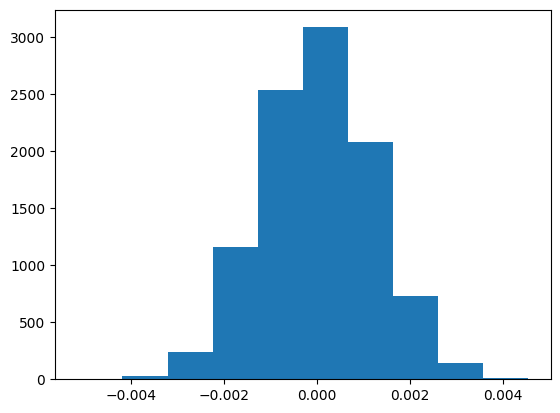

In [26]:
plt.hist(p_diffs);

In [27]:
#create a random sample for the null values
null_vals=np.random.normal(0,np.std(p_diffs),10000)

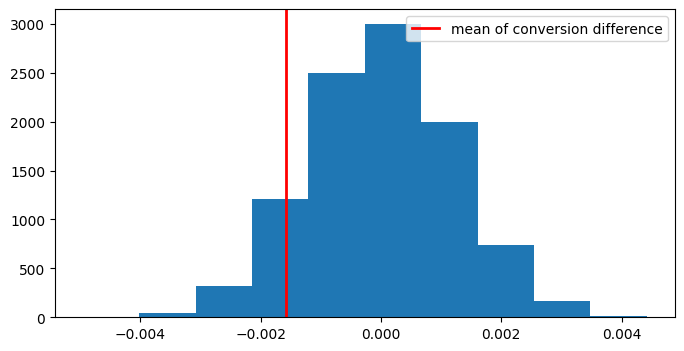

In [28]:
plt.figure(figsize=(8, 4))
plt.hist(null_vals);
plt.axvline(ab_data_diff,color='r',linewidth=2,label='mean of conversion difference');
plt.legend();

Calculating the P-Value

In [29]:
#Calculate the P-value
(null_vals > ab_data_diff).mean()

0.9062

Conclusion: 
------------

This value represents the p-value which is the probability of observing the statistic given the Null is true. As the p-value is large enough, we would fail to reject the Null hypothesis and so we will keep the old page. In other words, there is a high probability that any observed difference in the data is due to chance variation alone.

---

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm
import scipy.stats as st
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value. 

**link:**( https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
z_score, p_value

(1.3109241984234394, 0.09494168724097551)

In [38]:
z_critical=st.norm.ppf(.95)
z_critical

1.6448536269514722

Conclusion:
-------------

1) We have here z_score = 1.310924 which is less than the z_critical of(1.6448536),then we fail to reject null hypothesis. Therefore the conclusion is same as above in j and k that we accept null hypothesis.

2) We have 2 tests with error of 5% and then we fail to reject null hypothesis means that there is no signoficance effect from the new page on the conversion rate.


---

<a id='regression'></a>
### Part III - A regression approach

We have here two categorical outcomes a Yes-No type of variable (converted), the appropriate approach is Logistic Regression.

In [44]:
# create dummy variables from the group column
df2[['control','ab_page']] = pd.get_dummies(df2['group'], dtype= int)
# drop the baseline treatment column
df2 = df2.drop('control', axis = 1)
# create intercept column
df2['intercept'] = 1
# check to make sure the columns are added and to compare with old df2
# dataframe above
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


### Model 1

In [45]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])


In [46]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:               8.077e-06
Time:                        00:39:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


The p-value = 0.190 because of the type of test. As can be seen by the formulated hypotheses, in Part II we had a one-tailed test whereas in Part III a two tailed test.

As we can saw in **part II**  we have hypothesis of : We performed a one-sided test

$$ H_0 : \mu_{p_{new}}- \mu_{p_{old}}<= 0$$


$$H_1 : \mu_{p_{new}}- \mu_{p_{old}} > 0$$

While in **part III** we have hypothesis of :

$$ H_0 : \mu_{p_{new}}- \mu_{p_{old}}= 0$$


$$H_1 : \mu_{p_{new}}- \mu_{p_{old}} ≠ 0$$

The p-value here suggests that the group variable of (treatment and control) is not statistically significant enough in predicting of the conversion also tend to fail rejecting the null hypothesis as p-value is greater than aplha 

 Considering other things that might influence an individual converts is a good idea as these factors may contribute to the significance of our test results and leads to more accurate decisions .

**Disadvantages**
1. Additional terms will always improve the model whether the new term adds significant value to the model or not. As a matter of fact, adding new variables can actually make the model worse. Adding more and more variables makes it more and more likely that you will overfit your model to the training data.

2. Adding more independent variables or predictors to a regression model tends to increase the R-squared value, which tempts makers of the model to add even more variables. This is called overfitting and can return an unwarranted high R-squared value.


<a id='conclusions'></a>
## Conclusions

##### At last, We have done two parts of analysis :
**Part II**

We have done test on the the type of page that the user converts where the hypothesis is:

$$ H_0 : \mu_{p_{new}}- \mu_{p_{old}}<= 0$$


$$H_1 : \mu_{p_{new}}- \mu_{p_{old}} > 0$$

And we have make a 3 ways to know whether to reject or accept null hypothesis 

1. The sample mean lies on the null hypothesis distribution which let us  fail to reject the null hypothesis 
2. Also, We have calculated the p-value which is equal to 0.9043 that is very high value compared to 0.05 (error)
3. We have calculated the z-score here and z-critical and we have conclude that z-score is less than the z-critical (1.310924 < 1.6448536) that will force us to accept our null hypothesis 

So, this part we have concluded that the type of page has no effect on what the user converts


**Part III**

We have confirmed the part II using Logistic regression but with different hypothesis :

$$ H_0 : \mu_{p_{new}}- \mu_{p_{old}}= 0$$


$$H_1 : \mu_{p_{new}}- \mu_{p_{old}} ≠ 0$$

Where our p-value in:
1. the first model that see the effect of group on conversion is 0.190 which is greater than alpha, then we will also fail to reject the the null hypothesis as analysis on part II
2. the second model that see the effect of country with page type on what the user converts, But also find that all p-value are greater than the alpha which confirm that country and page type has no significance 
3. the third model that see the effect of interation of country with page type and page type on what the user converts , But also find that all p-value are greater than the alpha 
4. the fourth model that see the effect of country only on what the user converts,but sadly all p-value are greater than the alpha

At last all of the p-values of four models is confirming that country or page type have no statistically significance on predicting if the user will convert or not